# Examination dynamics

In [3]:
import sys
from pathlib import Path
sys.path.insert(1, '../../src/SEIR/')
sys.path.insert(1, '../../src/utils/')

from datetime import datetime
import numpy as np
from numpy import linalg as LA
import pandas as pd
from time import time
import multiprocessing
from joblib import Parallel, delayed
import time
import easygui
#import matplotlib
#matplotlib.axes.Axes.text
#matplotlib.pyplot.text

import platform
OS = platform.system()

import matplotlib.pyplot as plt

if OS == 'Linux':    
    %matplotlib tk
    print('Linux')
elif OS == 'Windows': 
    %matplotlib qt
    print('Windows')
else:
    print('OS not detected :-|')

from class_SEIRQ import SEIR
from Quarantine import Quarantine
from Quarantine import Exams

Linux


# Estudio de tiempos Seriales
Estudio del efecto que tienen distintos tiempos seriales en el efecto de las estrategias de examinación. El tiempo serial se puede calcular de la siguiente manera:  
$T_s = (\frac{1}{\gamma} + \frac{1}{\sigma})$ 

Para este estudio fijarémos $\frac{1}{\sigma}$ en 2 días, y utilizaremos un rango de valores comprendidos entre 1 y 20 días para $\frac{1}{\gamma}$.

Trabajaremos con un beta fijo y con un rango de valores para tasas de exámenes $(\lambda)$ y demora en la obtención de los resultados.  
Valores:  

* $\frac{1}{\sigma} = 2$ días  
* $\frac{1}{\gamma} \in [1,20]$ días  
* $\beta = 0.15$  
* $T_T \in [0,7]$ días 
* $\lambda \in [1,20] \%$ de la población de exámenes diarios  


In [4]:
mu = 0 # E0/I0 initial rate
sigma = 1/5
gamma = [1/i for i in range(1,21)]

SeroPrevalence = 1
expinfection = 0

# Simulation time
tsim = 1000
# Population
population = 100000
# Initial Active Infected 
I0 = 100
I_ac0 = 100

# Quarantine
s1 = Quarantine(1)

duty = 1
period = 1
testaccuracy=0.9
lambda_Tr = 0 # traceability
lambda_Q=1 # Proportion of effectively quarantined detected infected
T_Q = 14 # Time in quarantine

# Exam Rate
examrate = np.arange(1,21,1)*population/100# Persons per day

# Delay Time
T_T = np.arange(0.0,7.5,0.5)
# Beta
beta = 0.15

psi = [Exams(i,period,duty) for i in examrate] 

In [5]:
# Define Simulations
sims_reference = []
for i in range(len(gamma)):
    sims_reference.append(SEIR(tsim=tsim,alpha=s1.alpha,psi = 0,beta=beta,sigma=sigma,gamma=gamma[i],mu=mu,I0=I0,population=population,expinfection=0,testaccuracy=testaccuracy,lambda_Q=lambda_Q,T_T = 1,T_Q = T_Q,lambda_Tr=lambda_Tr))

## Reference Simulation
Here we simulate situations without exams that will serve as references

In [6]:
# For parallel simulation
def simulate_reference(simulation,tsim):
    simulation.integr_sci(0,tsim,0.1)
    return simulation

# Reference simulation
# Run simulation
start = time.time()
num_cores = multiprocessing.cpu_count()
simulation_reference = Parallel(n_jobs=num_cores, verbose=50)(delayed(simulate_reference)(sims_reference[i],tsim) for i in range(len(gamma)))
end = time.time()
easygui.msgbox('simulation finished - duration: '+str(end-start)+' seconds', title="SEIRTQ")

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=12)]: Done   2 out of  20 | elapsed:    1.4s remaining:   12.8s
[Parallel(n_jobs=12)]: Done   3 out of  20 | elapsed:    1.5s remaining:    8.4s
[Parallel(n_jobs=12)]: Done   4 out of  20 | elapsed:    1.5s remaining:    6.0s
[Parallel(n_jobs=12)]: Done   5 out of  20 | elapsed:    1.5s remaining:    4.5s
[Parallel(n_jobs=12)]: Done   6 out of  20 | elapsed:    1.5s remaining:    3.6s
[Parallel(n_jobs=12)]: Done   7 out of  20 | elapsed:    1.5s remaining:    2.9s
[Parallel(n_jobs=12)]: Done   8 out of  20 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=12)]: Done   9 out of  20 | elapsed:    1.6s remaining:    1.9s
[Parallel(n_jobs=12)]: Done  10 out of  20 | elapsed:    1.6s remaining:    1.6s
[Parallel(n_jobs=12)]: Done  11 out of  20 | elapsed:    1.6s remaining:    1.3s
[Parallel(n_jobs=12)]: Done  12 out of  20 | elapse

'OK'

In [7]:
# Define Simulations
sims = []
for i in range(len(examrate)):
    aux = []
    for j in range(len(gamma)):
        aux2 = []
        for k in range(len(T_T)):
            aux2.append(SEIR(tsim=tsim,alpha=s1.alpha,psi = psi[i],beta=beta,sigma=sigma,gamma=gamma[j],mu=mu,I0=I0,population=population,expinfection=0,testaccuracy=testaccuracy,lambda_Q=lambda_Q,T_T = T_T[k],T_Q = T_Q,lambda_Tr=lambda_Tr))
        aux.append(aux2)
    sims.append(aux)

In [8]:
#%%capture
# To show the cell's output comment the former line
# For parallel simulation
start = time.time()
def simulate(simulation,k,tsim):
    simulation[k].integr_sci(0,tsim,0.1)
    return simulation[k]

# Run simulation
num_cores = multiprocessing.cpu_count()
simulation = []
for i in range(len(examrate)):
    aux = []
    for j in range(len(gamma)):
        aux.append(Parallel(n_jobs=num_cores, verbose=50)(delayed(simulate)(sims[i][j],k,tsim) for k in range(len(sims[i][j]))))
    simulation.append(aux)
end = time.time()
easygui.msgbox('simulation finished - duration: '+str(end-start)+' seconds', title="SEIRTQ")

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.1424s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elap

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0687s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0738s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.1173s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0709s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.1256s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0704s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.1160s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0984s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0861s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.1034s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 

[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0515s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0902s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 

[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0497s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.

[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks     

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.1310s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0574s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0786s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 

[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0622s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.

[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0912s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0600s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.

[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 

[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Using backend L

[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0841s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0722s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.1066s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0576s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.1256s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0745s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.1191s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0609s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.1068s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend L

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0857s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.1338s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend L

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0920s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.1209s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0588s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.1140s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend L

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0721s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.1097s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0872s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.1193s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.9s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.1011s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0793s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  13 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  15 out of  15 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Batch computation too fast (0.0872s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done   2 out of  15 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=12)]: Done   3 out of  15 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=12)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=12)]: Done   5 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   7 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=12)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done   9 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  11 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  15 | 

'OK'

In [9]:
# Calculate indicators
peak = []
for i in range(len(examrate)):
    aux = []
    for j in range(len(gamma)):
        aux2 = []
        for k in range(len(T_T)):
            aux2.append(100*simulation[i][j][k].peak/population)
        aux.append(aux)
    peak.append(aux)

    
peaktime = []
for i in range(len(examrate)):
    aux = []
    for j in range(len(gamma)):
        aux2 = []
        for k in range(len(T_T)):
            aux2.append(simulation[i][j][k].peak_t)
        aux.append(aux2)
    peaktime.append(aux)

prevalence = []
for i in range(len(examrate)):
    aux = []
    for j in range(len(gamma)):
        aux2 = []
        for k in range(len(T_T)):        
            aux2.append(simulation[i][j][k].prevalence_total[-1])  
        aux.append(aux2)
    prevalence.append(aux)
prevalence = np.array(prevalence)
    
# Calculate indicators
peakvsnoexam = []
for i in range(len(examrate)):
    aux = []
    for j in range(len(gamma)):
        aux2 = []
        for k in range(len(T_T)):        
            aux2.append(simulation[i][j][k].I/np.max(simulation_reference[j].I))
        aux.append(aux2)
    peakvsnoexam.append(aux)
#peakvsnoexam = np.array(peakvsnoexam)
# Calculate indicators
totinfected = []
for i in range(len(examrate)):
    aux = []
    for j in range(len(gamma)):
        aux2 = []
        for k in range(len(T_T)):        
            aux2.append(100*simulation[i][j][k].I_ac[-1]/simulation_reference[j].I_ac[-1])
        aux.append(aux2)
    totinfected.append(aux)

totinfected = np.array(totinfected)

In [10]:
test = []
for i in range(len(examrate)):
    aux = []
    for j in range(len(gamma)):
        aux2 = []
        for k in range(len(T_T)):        
            aux2.append(100*simulation[i][j][k].peak)
        aux.append(aux2)
    test.append(aux)
test = np.array(test)

In [11]:
peak_reference = []
for j in range(len(gamma)):
    peak_reference.append(simulation_reference[j].peak)

# Plots

## Plot 1: Grid Epidemic plots

In [12]:
saveplot = False

In [17]:
if saveplot:
    %matplotlib inline
%matplotlib inline    

plt.rcParams["figure.figsize"] = 38.40, 20.56 #8,6
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif":["Arial"]})

 

In [18]:
gamma[4]

0.2

In [19]:
examrate[9]/population

0.1

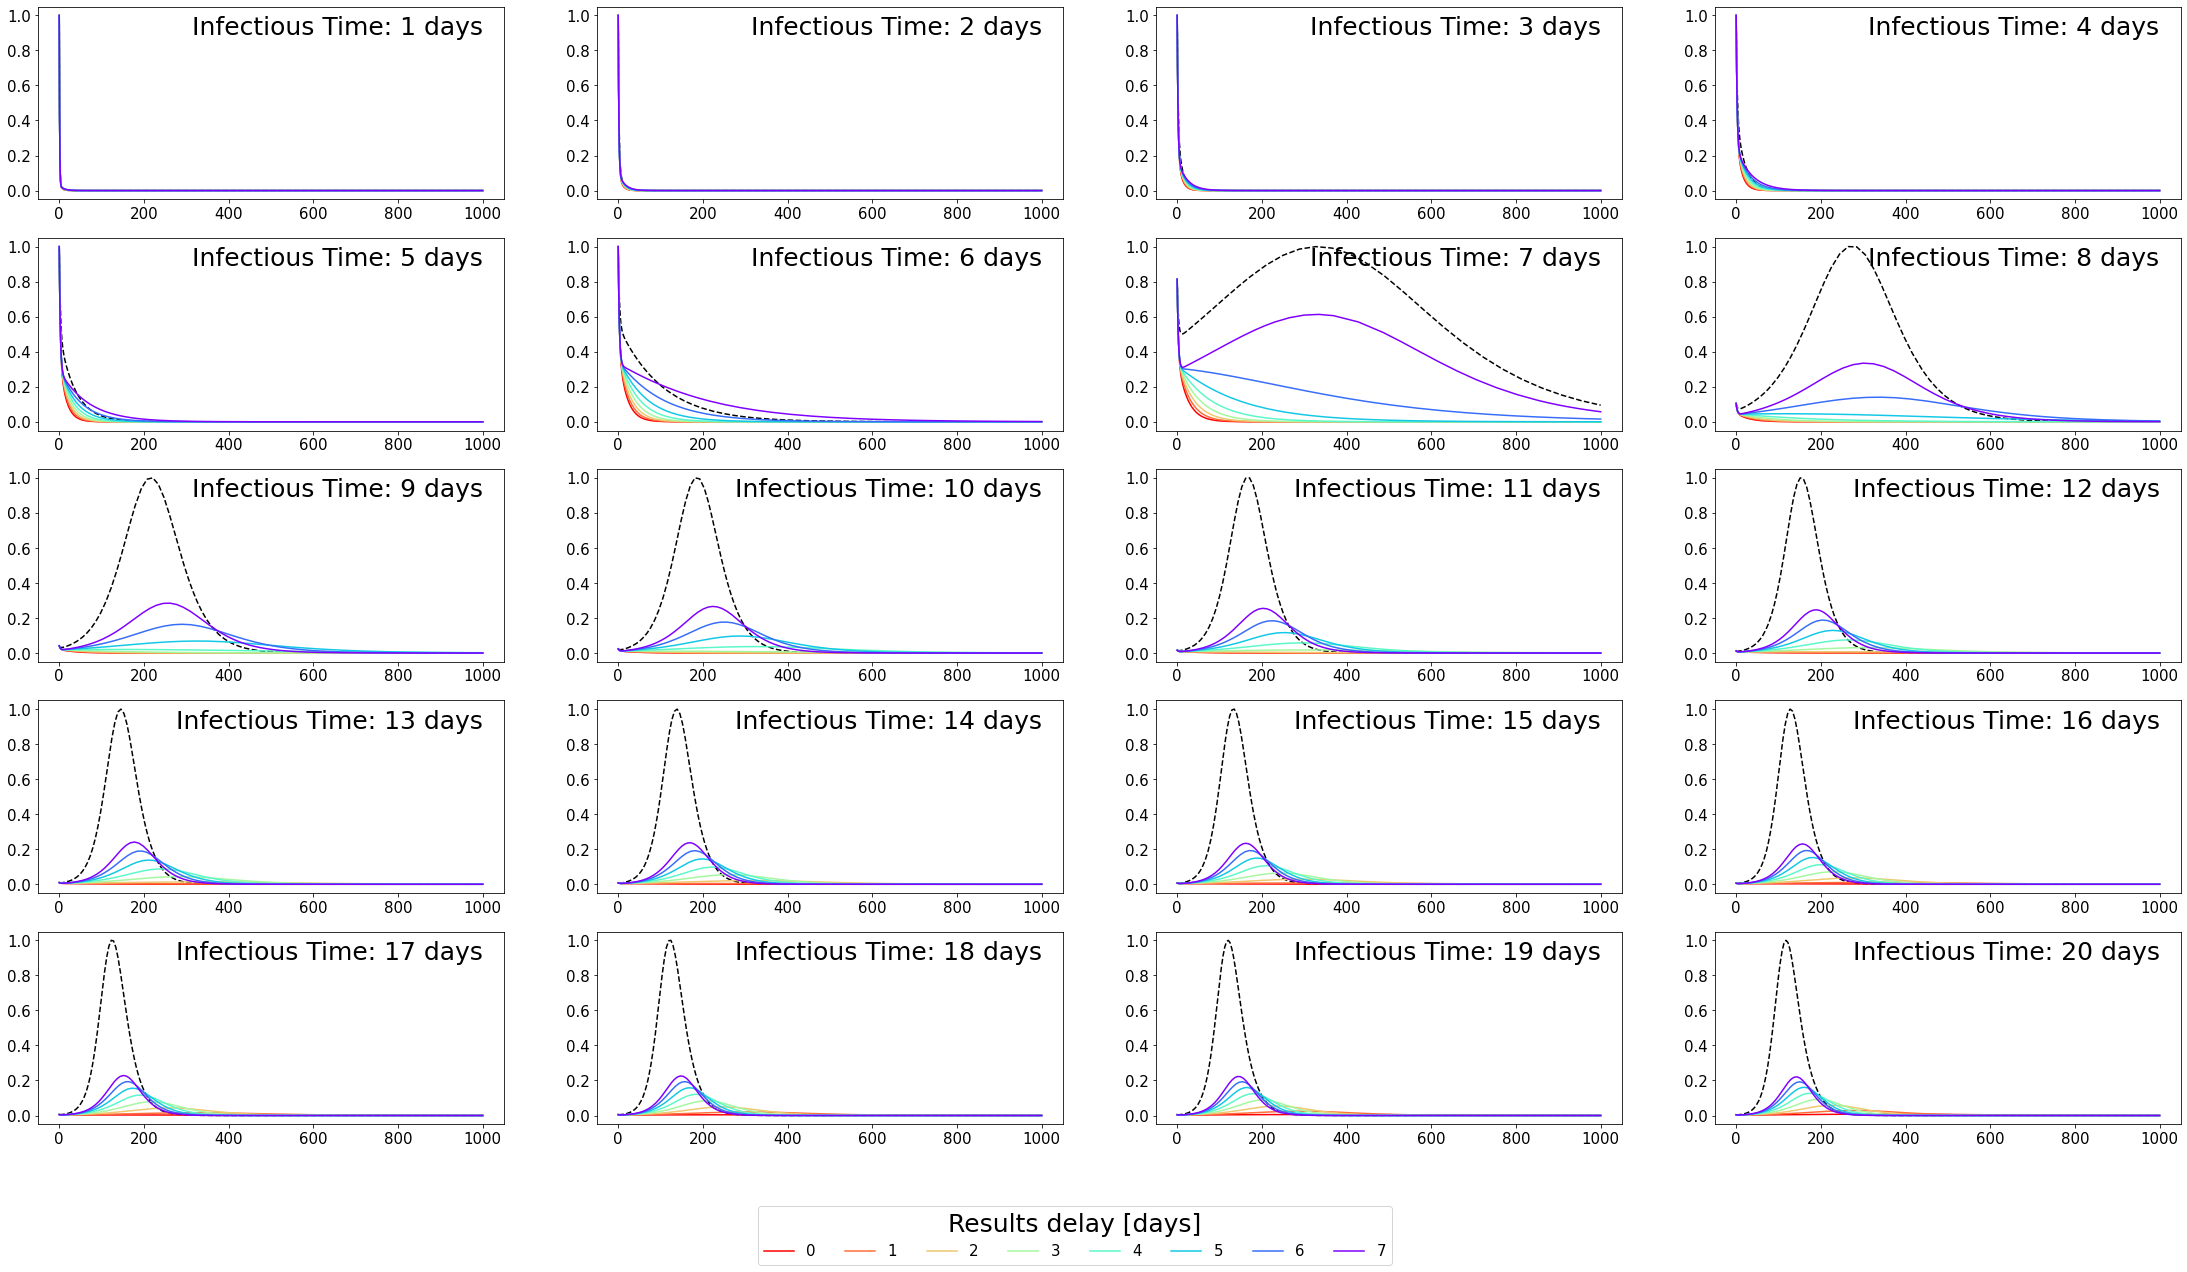

In [20]:
colors = plt.cm.rainbow_r(np.linspace(0,1,int(len(T_T)/2+1)))
levels = np.arange(0,105,5)
n = 4
i = 9 # 10% of exams
fig, axs = plt.subplots(int(len(examrate)/n)+(int(len(examrate))%n > 0)*1, n)
for j in range(len(gamma)):
    axs[int(j/n),j%n].plot(simulation_reference[j].t,simulation_reference[j].I/np.max(simulation_reference[j].I),color = 'black',linestyle='dashed')#label='I_d No exams'
    for k in range(int(len(T_T)/2)+1):
        axs[int(j/n),j%n].plot(simulation[i][j][k*2].t,simulation[i][j][k*2].I/np.max(simulation_reference[j].I),color=colors[k])
        axs[int(j/n),j%n].tick_params(labelsize=15)
        if int(i/n)==4: 
            axs[int(j/n),j%n].set_xlabel('Days',size=25)
        if i%n==0:
            axs[int(j/n),j%n].set_ylabel('Active Infected',size=25)
    #axs[int(i/n),i%n].set_title('Exam Rate: '+str(round(examrate[i]/population*100))+'%')
    #axs[int(i/n),i%n].plot([],[],label='Exam Rate: '+str(round(examrate[i]/population*100))+'%')
    axs[int(j/n),j%n].text(1000, 1,'Infectious Time: '+str(round(1/gamma[j]))+' days', {'fontsize': 25},horizontalalignment='right',verticalalignment='top')
    #axs[int(i/n),i%n].legend(loc=0,fontsize=15)  

# Legend 
for k in range(int(len(T_T)/2)+1):
    axs[0,0].plot([],[],color=colors[k],label=str(int(T_T[k*2])))
fig.legend(loc='lower center',bbox_to_anchor=(0.5, 0.025),ncol=int(len(T_T)/2)+1,title = 'Results delay [days]',fontsize='15',title_fontsize='25')    

if saveplot:
    plt.savefig('plot1.pdf',dpi=100,format='pdf')
plt.show()

## Plot 2: Tests vs Delay para distintos gamma

### Total infected normalized by the dynamic with no exams

In [21]:
saveplot = False

In [22]:
if saveplot:
    %matplotlib inline
%matplotlib inline
plt.rcParams["figure.figsize"] = 38.40, 20.56
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif":["Arial"]})

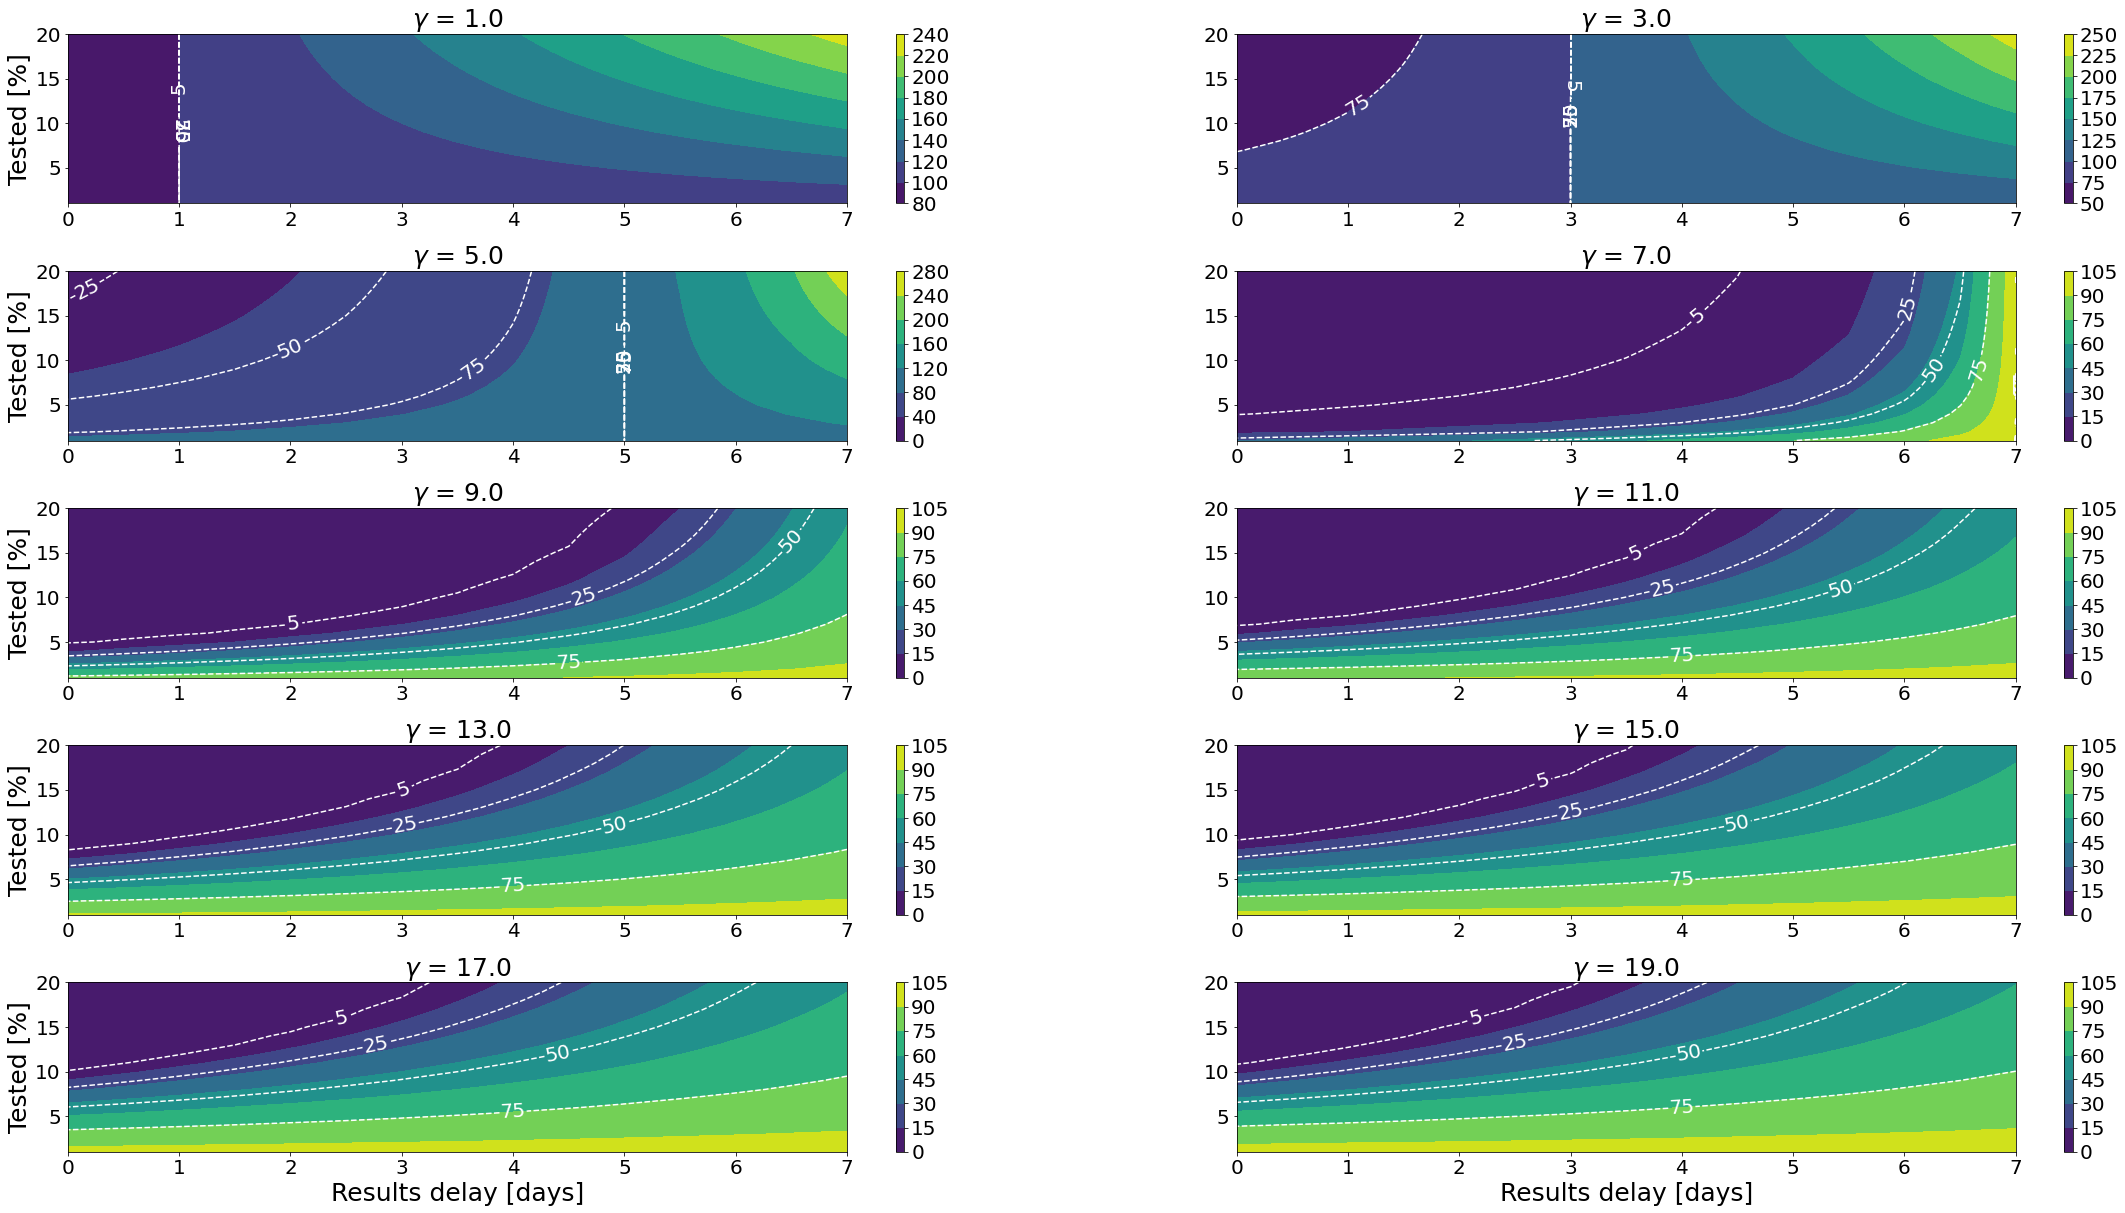

In [24]:
# Contour Plot
levels = np.arange(0,105,5)
# Colormap:
# https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
# jet , hsv , Greys , YlOrRd
colors = plt.cm.BuPu(np.linspace(0,1,int(len(levels)+1)))

levelcourves = [5,25,50,75]
#levelcourves = []
n = 2

fig,ax=plt.subplots(5,2)
for j in range(int(len(gamma)/2)):    
    cp = ax[int(j/n),j%n].contourf(T_T,examrate*100/population,totinfected[:,2*j,:])     
    for l in levelcourves:
        cp2 = ax[int(j/n),j%n].contour(T_T,examrate*100/population,totinfected[:,2*j,:],[0,l,100],colors='white',linestyles='dashed')
        ax[int(j/n),j%n].clabel(cp2, inline=1, fontsize=20,fmt=str(l))
    ax[int(j/n),j%n].set_title(r'$\gamma$ = '+str(round(1/gamma[j*2],2)),fontsize=25)
    ax[int(j/n),j%n].tick_params(labelsize=20)
    if int(j/n)==4: 
        ax[int(j/n),j%n].set_xlabel('Results delay [days]',size=25)        
    if j%n==0:
        ax[int(j/n),j%n].set_ylabel('Tested [%]',size=25)
    
    cbar = fig.colorbar(cp, ax=ax[int(j/n),j%n]) # increase fontsize
    cbar.ax.tick_params(labelsize=20)
    
#fig.suptitle('Total infected proportion to the dynamic with no exams')
#plt.tight_layout()
plt.subplots_adjust(hspace=0.4)

if saveplot:
    plt.savefig('plot2.pdf',dpi=100,format='pdf')
plt.show() 
#fig.colorbar(cp) # Add a colorbar to a plot
#fig.colorbar(cp, ax=ax)


## Plot 3: Test vs Beta para distintos delay

In [27]:
saveplot = True

In [30]:
if saveplot:
    %matplotlib inline

plt.rcParams["figure.figsize"] = 38.40, 20.56
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif":["Arial"]})

<ipython-input-35-aedd9072c089>:12: UserWarning: No contour levels were found within the data range.
  cp2 = ax[int(k/n),k%n].contour(beta,examrate*100/population,totinfected[:,:,k*2],[0,l,100],colors='white',linestyles='dashed')


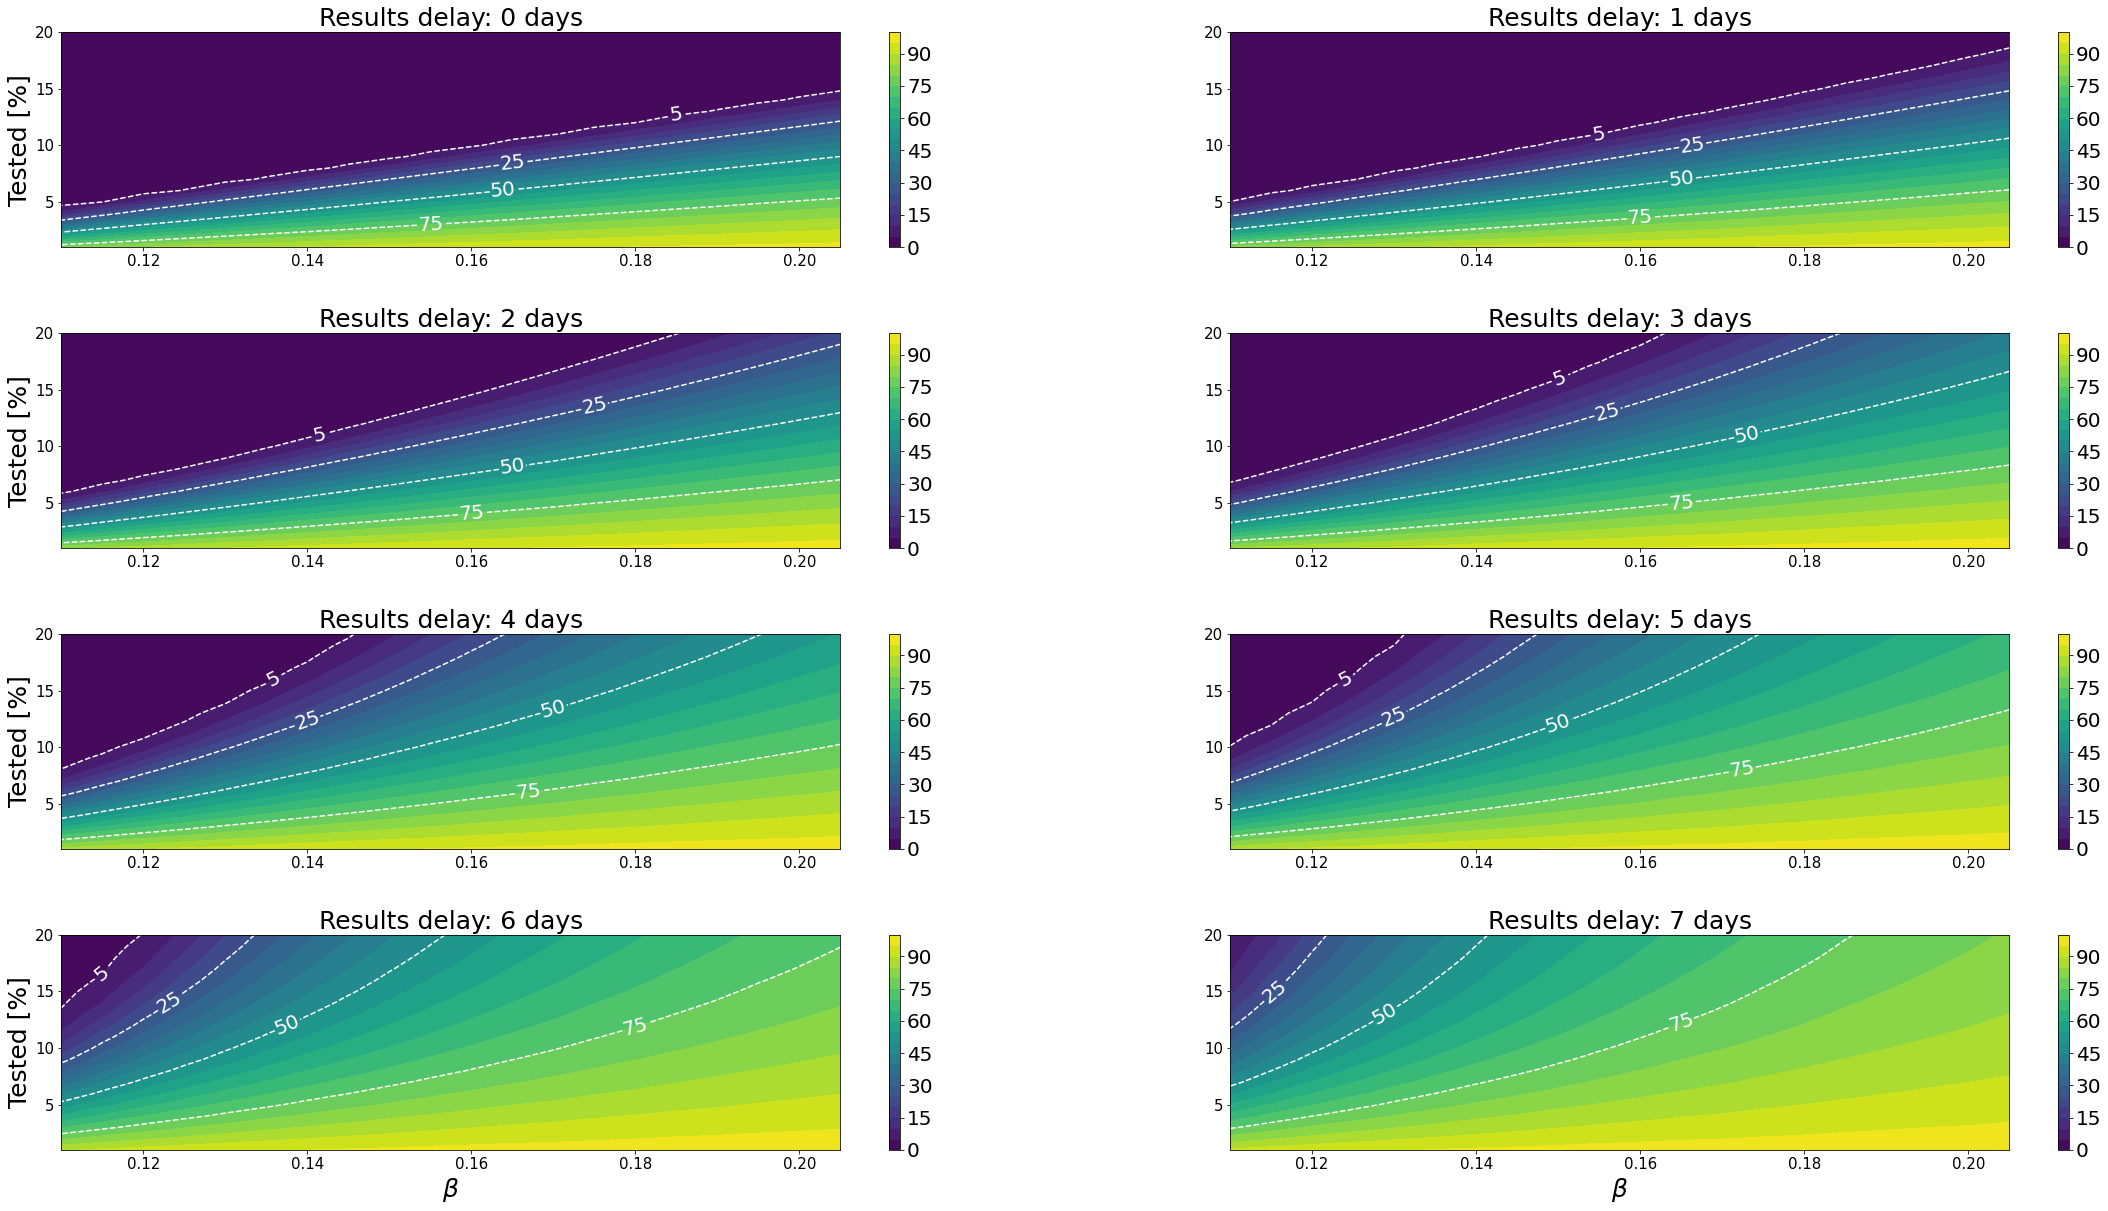

In [35]:
# Contour Plot
levels = np.arange(0,105,5)
levelcourves = [5,25,50,75]
#levelcourves = []
n = 2

fig,ax=plt.subplots(4,2)
for k in range(round(len(T_T)/2)):    
    cp = ax[int(k/n),k%n].contourf(beta,examrate*100/population,totinfected[:,:,k*2],levels)     
    ax[int(k/n),k%n].set_title('Results delay: '+str(int(T_T[k*2]))+' days',fontsize=25)
    for l in levelcourves:
        cp2 = ax[int(k/n),k%n].contour(beta,examrate*100/population,totinfected[:,:,k*2],[0,l,100],colors='white',linestyles='dashed')        
        if np.min(totinfected[:,:,k*2])<l<np.max(totinfected[:,:,k*2]):
            ax[int(k/n),k%n].clabel(cp2, inline=1, fontsize=20,fmt=str(l))
    ax[int(k/n),k%n].tick_params(labelsize=15)
    if int(k/n)==3:
        ax[int(k/n),k%n].set_xlabel(r'$\beta$',size=25)
    if k%n==0:
        ax[int(k/n),k%n].set_ylabel('Tested [%]',size=25)
    cbar = fig.colorbar(cp, ax=ax[int(k/n),k%n])
    cbar.ax.tick_params(labelsize=20)
plt.subplots_adjust(hspace=0.4)
#fig.set_size_inches(13, 8)
if saveplot:
    plt.savefig('plot3.pdf',dpi=100,format='pdf')
plt.show() 
#fig.colorbar(cp) # Add a colorbar to a plot
#fig.colorbar(cp, ax=ax)

## Plot4: Delay vs beta para distintas tasas de exámenes (Completitud)

In [32]:
saveplot = True

In [33]:
if saveplot:
    %matplotlib inline

plt.rcParams["figure.figsize"] = 38.40, 20.56
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif":["Arial"]})

<ipython-input-34-35da2ca38e99>:12: UserWarning: No contour levels were found within the data range.
  cp2 = ax[int(i/n),i%n].contour(T_T,beta,totinfected[i,:,:],[0,l,100],colors='white',linestyles='dashed')
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


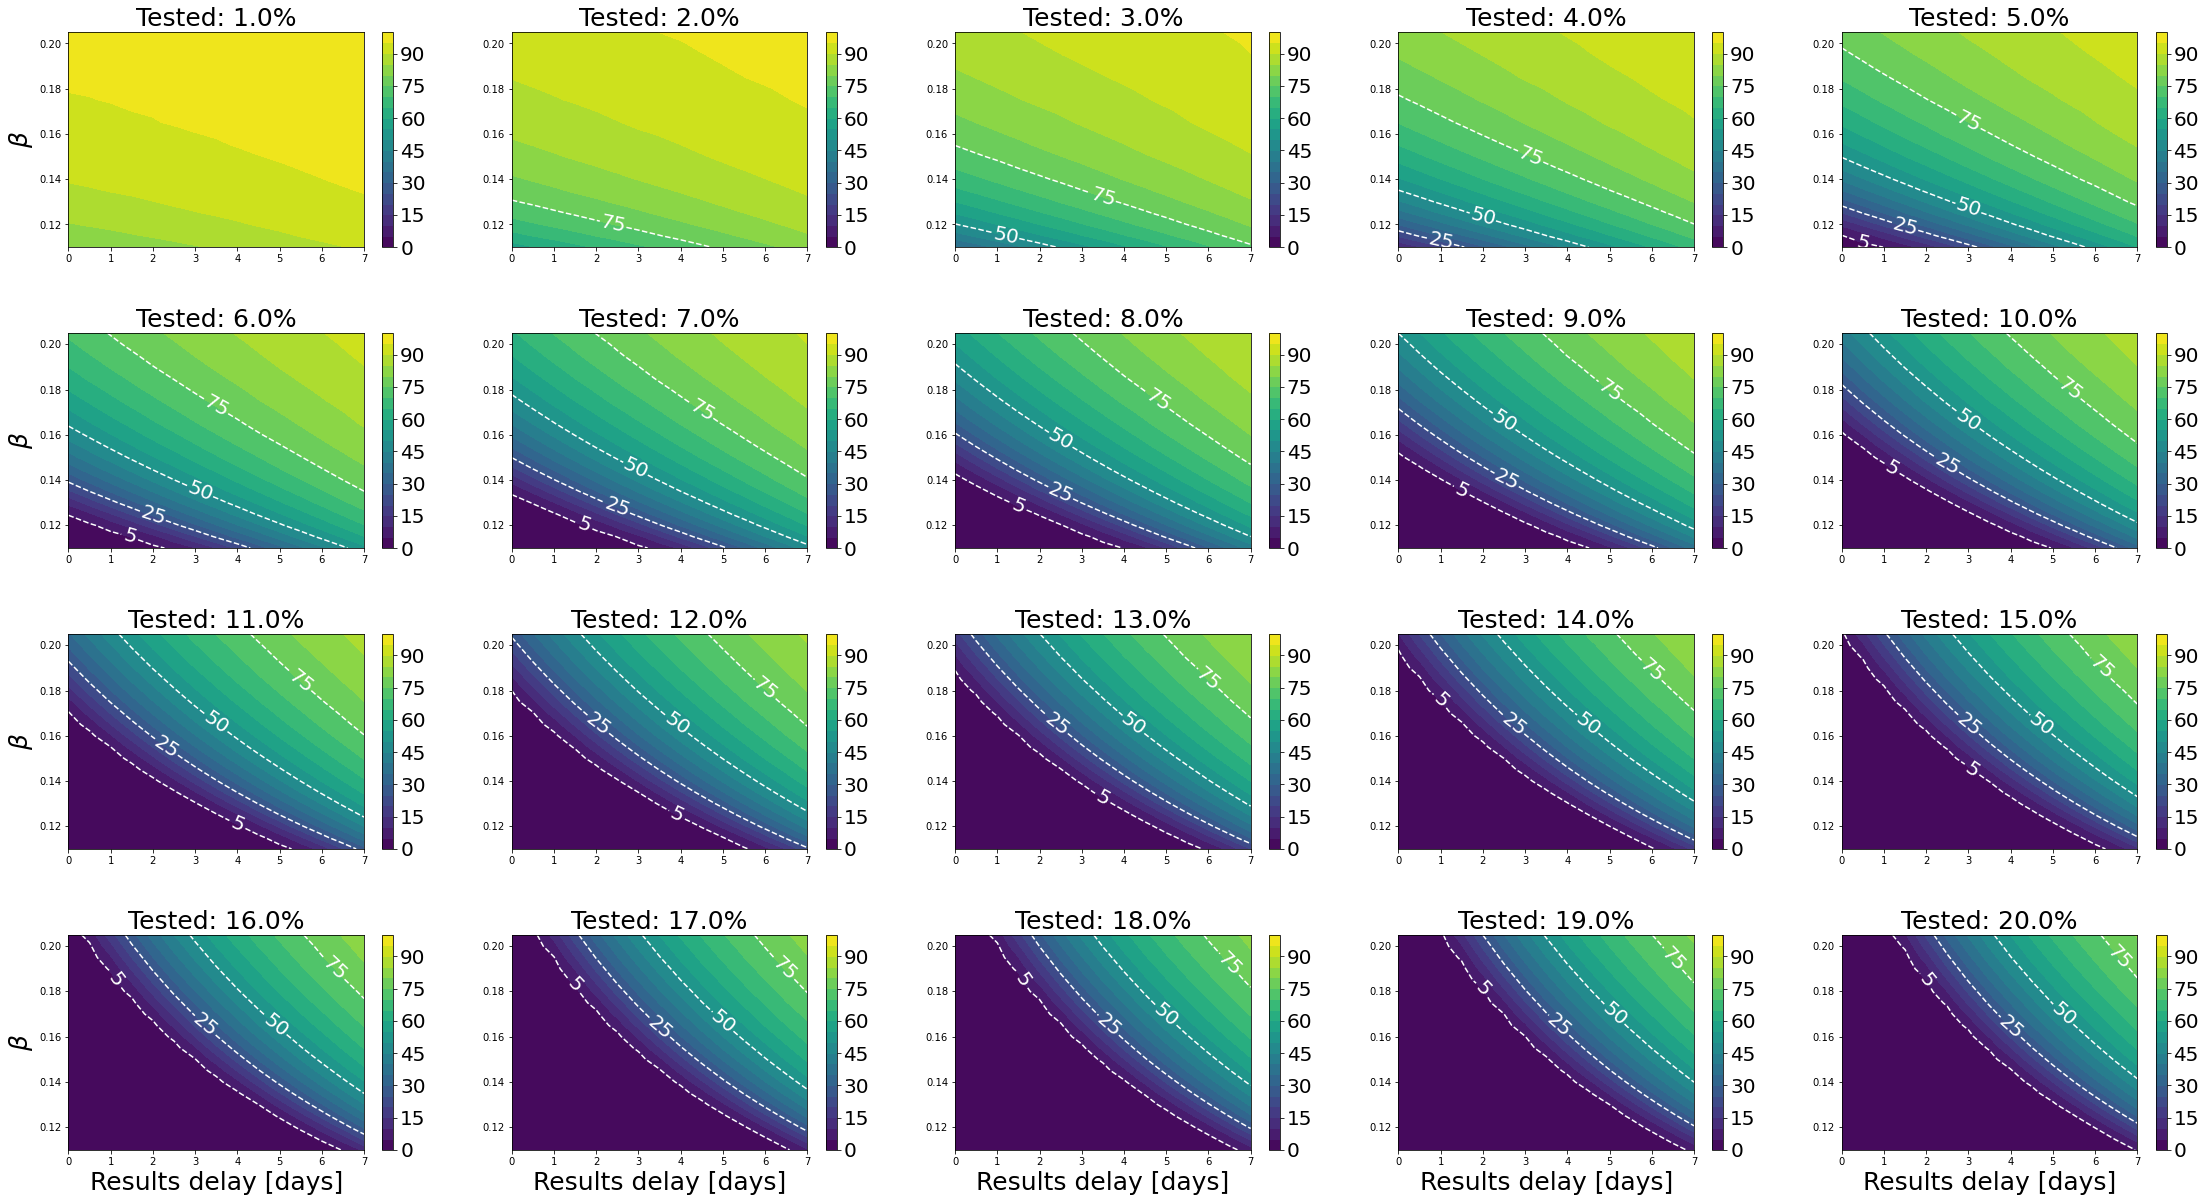

In [34]:
# Contour Plot
levels = np.arange(0,105,5)
levelcourves = [5,25,50,75]
#levelcourves = []
n = 5

fig,ax=plt.subplots(4,5)
for i in range(len(examrate)):    
    cp = ax[int(i/n),i%n].contourf(T_T,beta,totinfected[i,:,:],levels)
    ax[int(i/n),i%n].set_title('Tested: '+str(100*(examrate[i])/population)+'%',fontsize=25)
    for l in levelcourves:
        cp2 = ax[int(i/n),i%n].contour(T_T,beta,totinfected[i,:,:],[0,l,100],colors='white',linestyles='dashed')        
        if np.min(totinfected[i,:,:])<l<np.max(totinfected[i,:,:]):
            ax[int(i/n),i%n].clabel(cp2, inline=1, fontsize=20,fmt=str(l))
        
    if int(i/n)==3:
        ax[int(i/n),i%n].set_xlabel('Results delay [days]',size=25)    
    if i%n==0:
        ax[int(i/n),i%n].set_ylabel(r'$\beta$',size=25)    
    cbar = fig.colorbar(cp, ax=ax[int(i/n),i%n])
    cbar.ax.tick_params(labelsize=20)

plt.subplots_adjust(hspace=0.4)
if saveplot:
    plt.savefig('plot4.pdf',dpi=100,format='pdf')
plt.show() 

## Plot curvas de nivel (Paper UCL)

In [27]:
saveplot = True

In [30]:
if saveplot:
    %matplotlib inline

plt.rcParams["figure.figsize"] = 38.40, 20.56
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif":["Arial"]})

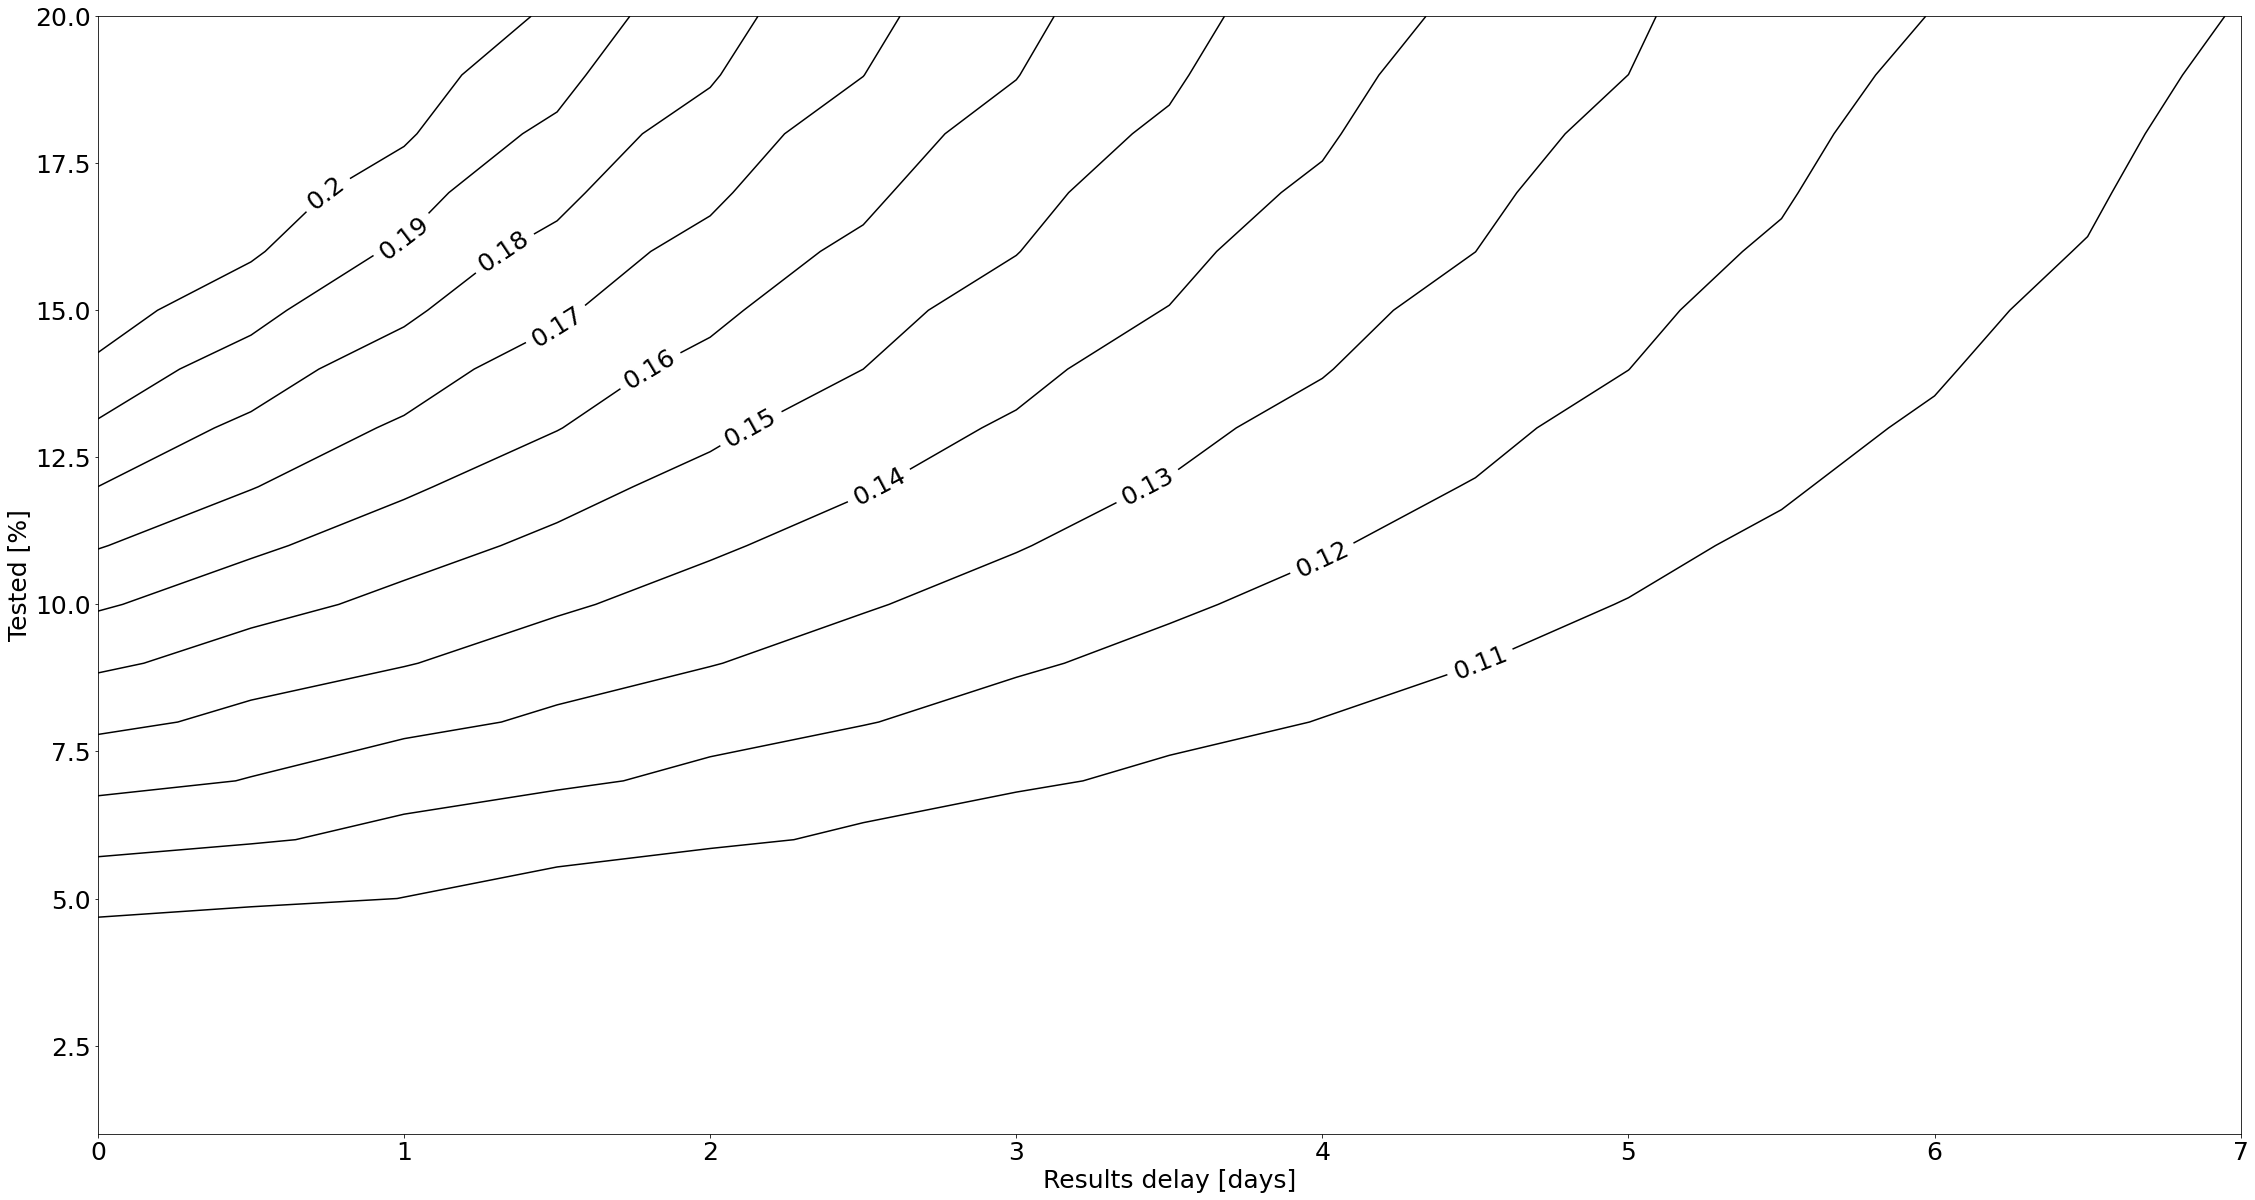

In [39]:
color = False

levels = [0,5,100]
colors = plt.cm.jet(np.linspace(0,1,int(len(beta)/2)))

n = 3
fig,ax=plt.subplots(1,1)
#ax.set_title('Beta: '+str(round(beta[j],2)))
ax.set_xlabel('Results delay [days]',size=25)
ax.set_ylabel('Tested [%]',size=25)  
ax.tick_params(labelsize=25)
for j in range(int(len(beta)/2)):
    if color:
        cp = ax.contour(T_T,examrate*100/population,totinfected[:,2*j,:],levels,colors=colors[j]) 
    else:
        cp = ax.contour(T_T,examrate*100/population,totinfected[:,2*j,:],levels,colors='black') #colors[j]
        #cp = ax.contourf(T_T,examrate*100/population,beta)         # Agregar gradiente de beta
    ax.clabel(cp, inline=1, fontsize=25,fmt=str(round(beta[2*j],2)))

if saveplot:
    if color:
        plt.savefig('plotContourBeta_color.pdf',dpi=100,format='pdf')
    else:
        plt.savefig('plotContourBeta_byn.pdf',dpi=100,format='pdf')
plt.show() 

